<a href="https://colab.research.google.com/github/AlessandroTaglieri/Project_Bioinformatics/blob/main/First%20project/BI_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#comment if not running on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import libraries
import pandas as pd
import os
import numpy as np
import collections

In [3]:
#change project folder to match yours
project_folder ='/content/drive/MyDrive/BioinfoProject/Project_Bioinformatics/First_project/'
#project_folder ='/'

In [4]:
#change dataset folder to match yours
dataset_folder = os.path.join(project_folder,'dataset/')

In [6]:
#only in local
#dataset_folder="dataset/"

# 1.1

In [5]:
#download curated gene-diesase associtaions from https://www.disgenet.org/downloads and covnert tsv in csv

data = pd.read_csv(dataset_folder+ '1.1/curated_gene_disease_associations.csv')
#get only data for intereted gene id C0043094
gene_disease = data.loc[data['diseaseId'] == 'C0043094']

#get list og gene symbols
list_geneSymbol = gene_disease['geneSymbol']


#download hgnc dataset from https://www.genenames.org/download/statistics-and-files/
hgnc = pd.read_csv(dataset_folder+ "1.1/hgnc_complete_set.txt", sep='\t', dtype = 'unicode')

#get data (symbol,name,entrez_id,unirpot_idasdn status) for only genes stored in previous list
genes_diseases_hgnc = hgnc.loc[hgnc['symbol'].isin(list_geneSymbol)][['symbol','name','entrez_id','uniprot_ids','status']]

#get only approved data
genes_diseases_hgnc_app = genes_diseases_hgnc.loc[genes_diseases_hgnc['status']=='Approved']


#get list ofuniprotidthat we'll useto find gene descriptionin Uniprot
list_uniprotID = genes_diseases_hgnc_app['uniprot_ids']

#write in a file alll uniprot ids. This is necessary because we'll download only necessary description for these genes from uniprot 
with open(dataset_folder+ '1.1/uniprot_ids.txt', 'w') as f:
    for item in list_uniprotID:
        f.write("%s\n" % item)
    f.close()

#download data containing description for every gene. We used txt file for download them
gene_description = pd.read_csv(dataset_folder+ '1.1/uniprot-yourlist%3AM20201123A94466D2655679D1FD8953E075198DA817123DO.csv')

#rename column for the function of the gene
gene_description=gene_description.rename(columns={"yourlist:M20201123A94466D2655679D1FD8953E075198DA817123DO":"uniprot_ids"})

#merge two dataset. One containing all info about gene and the second one conatining description about their functions
final_genes_deseas = pd.merge(gene_description, genes_diseases_hgnc_app, on='uniprot_ids')
#rename column
final_genes_deseas=final_genes_deseas.rename(columns={"Function [CC]":"function"})
#get only first part of gene description
final_genes_deseas['Description']= final_genes_deseas.function.str[10:150]
#delete not necessary columns
final_genes_deseas = final_genes_deseas.drop(['function','Entry','status'], axis = 1) 
final_genes_deseas = final_genes_deseas[['symbol','uniprot_ids','name','entrez_id','Description']]

In [6]:
#fix column names and save xlsx file
final_genes_deseas.rename(columns={"symbol":"Gene symbol","uniprot_ids":"Uniprot AC","name":'Protein name','entrez_id':"Entrez Gene ID"})
final_genes_deseas.to_excel(dataset_folder+ '1.1/1.1-gene_deseas_associations.xlsx')
final_genes_deseas.to_csv(dataset_folder+ '1.1/1.1-gene_deseas_associations.csv')

In [7]:
final_genes_deseas

,symbol,uniprot_ids,name,entrez_id,Description
0,ABCG1,P45844,ATP binding cassette subfamily G member 1,9619,Catalyzes the efflux of phospholipids such as ...
1,ACADM,P11310,acyl-CoA dehydrogenase medium chain,34,Acyl-CoA dehydrogenase specific for acyl chain...
2,ACE,P12821,angiotensin I converting enzyme,1636,Converts angiotensin I to angiotensin II by re...
3,ADIPOQ,Q15848,"adiponectin, C1Q and collagen domain containing",9370,Important adipokine involved in the control of...
4,AHR,P35869,aryl hydrocarbon receptor,196,Ligand-activated transcriptional activator. Bi...
...,...,...,...,...,...
97,TSEN2,Q8NCE0,tRNA splicing endonuclease subunit 2,80746,Constitutes one of the two catalytic subunit o...
98,VIM,P08670,vimentin,7431,Vimentins are class-III intermediate filaments...
99,VPS13D,Q5THJ4,vacuolar protein sorting 13 homolog D,55187,Functions in promoting mitochondrial clearance...
100,ZDHHC2,Q9UIJ5,zinc finger DHHC-type palmitoyltransferase 2,51201,Palmitoyltransferase that catalyzes the additi...


In [8]:
## To save seed id and symbols correspondance
seed_symbols, seed_ids = final_genes_deseas['symbol'].values ,final_genes_deseas['entrez_id'].values
seed_symbols_to_ids = {}
seed_ids_to_symbols = {}
for key,value in zip(seed_symbols,seed_ids):
  seed_symbols_to_ids[key] = value
  seed_ids_to_symbols[value] = key


def seed_symbol_to_id(symbol):
  return seed_symbols_to_ids.get(symbol)

def seed_id_to_symbol(id):
  return seed_ids_to_symbols.get(id)


# 1.2

# Get biogrid data

In [9]:
#read biogrid dataset 
biogrid_datafile = dataset_folder+'1.2/BIOGRID-ORGANISM-Homo_sapiens-4.2.191.tab3.txt'
biogrid_data = pd.read_csv(biogrid_datafile,sep='\t')
#biogrid_data.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# Filter data to only physical interactions and Homo sapiens genes
biogrid_data = biogrid_data[biogrid_data['Experimental System Type']=='physical']
biogrid_data = biogrid_data[biogrid_data['Organism Name Interactor A']=='Homo sapiens']
biogrid_data = biogrid_data[biogrid_data['Organism Name Interactor B']=='Homo sapiens']

In [14]:
biogrid_data.head(5)

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,Synonyms Interactor B,Experimental System,Experimental System Type,Author,Publication Source,Organism ID Interactor A,Organism ID Interactor B,Throughput,Score,Modification,Qualifications,Tags,Source Database,SWISS-PROT Accessions Interactor A,TREMBL Accessions Interactor A,REFSEQ Accessions Interactor A,SWISS-PROT Accessions Interactor B,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,ABP-280|ABP280A|ABPA|ABPL|FLN2|MFM5|MPD4,Two-hybrid,physical,Marti A (1997),PUBMED:9006895,9606,9606,Low Throughput,-,-,-,-,BIOGRID,P45985,-,NP_003001|NP_001268364,Q14315,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,CMD1AA,Two-hybrid,physical,Bang ML (2001),PUBMED:11309420,9606,9606,Low Throughput,-,-,-,-,BIOGRID,Q86TC9,A0A087WX60,NP_001243197|NP_001243196|NP_115967,P35609,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,FPTA|PGGT1A|PTAR2,Two-hybrid,physical,Wang T (1996),PUBMED:8599089,9606,9606,Low Throughput,-,-,-,-,BIOGRID,Q04771,D3DPA4,NP_001104537|NP_001096,P49354,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,MYL|PP8675|RNF71|TRIM19,Two-hybrid,physical,Tsuzuki S (2000),PUBMED:10938104,9606,9606,Low Throughput,-,-,-,-,BIOGRID,P23769,-,NP_001139134|NP_116027|NP_001139133,P29590,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,ADMIO|APRF|HIES,Two-hybrid,physical,Kim J (2000),PUBMED:10875894,9606,9606,Low Throughput,-,-,-,-,BIOGRID,P15927,B4DUL2,NP_001342057|NP_002937|NP_001284487|NP_0013420...,P40763,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens


#### Mapping protein Id to symbols


In [18]:
biogrid_ids_A,biogrid_symbols_A  = biogrid_data['Entrez Gene Interactor A'].values ,biogrid_data['Official Symbol Interactor A'].values
biogrid_ids_B,biogrid_symbols_B  = biogrid_data['Entrez Gene Interactor B'].values ,biogrid_data['Official Symbol Interactor B'].values

symbols_to_ids = {}
ids_to_symbols = {}
for key,value in zip(biogrid_symbols_A,biogrid_ids_A):
  symbols_to_ids[key] = value
  ids_to_symbols[value] = key

for key,value in zip(biogrid_symbols_B,biogrid_ids_B):
  symbols_to_ids[key] = value
  ids_to_symbols[value] = key 
  

In [22]:
def symbol_to_id(symbol):
  id = symbols_to_ids.get(symbol)
  if id ==None:
    return seed_symbol_to_id(symbol)
  return id

def id_to_symbol(id):
  symbol = ids_to_symbols.get(id)
  if symbol == None:
    return seed_id_to_symbol(id)
  return symbol

def symbol_link_to_id_link(link):
  return (symbol_to_id(link[0]),symbol_to_id(link[1]))


##Get all nodes involved in interactions 


---



In [19]:
gene_A_list = biogrid_data.iloc[:,1].values
gene_B_list = biogrid_data.iloc[:,2].values
A_B_list = np.append(gene_A_list,gene_B_list)
A_set = set(gene_A_list)

B_set =  set(gene_B_list)
A_B_set = set(A_B_list)

In [23]:
genes_biogrid = np.array([id_to_symbol(x) for x in A_B_set if str.isdigit(str(x))])
genes_biogrid

array(['A1BG', 'A2M', 'CCDC58', ..., 'RPL10A', 'SPAG7', 'CPNE4'],
      dtype='<U22')

##Get all interactions 



In [24]:
interactions = biogrid_data.iloc[:,1:3].values
#interactions =np.array([[a,b] for a,b in interactions if(str.isdigit(str(a)) & str.isdigit(str(b)))])
interactions =np.array([[id_to_symbol(a),id_to_symbol(b)] for a,b in interactions ])
interactions.shape

(630323, 2)

In [25]:
interactions

array([['MAP2K4', 'FLNC'],
       ['MYPN', 'ACTN2'],
       ['ACVR1', 'FNTA'],
       ...,
       ['BCAR1', 'QTRTD1'],
       ['BCAR1', 'EPT1'],
       ['BCAR1', 'C12orf5']], dtype='<U22')

# Seed gene list 

In [26]:
seed_genes_ids  =  final_genes_deseas['entrez_id'].values
seed_genes_ids = [id_to_symbol(s) for s in seed_genes_ids]


#Now we build a dictionary of all interactions

In [27]:
all_interactions_dict = collections.defaultdict(set)
for a,b in interactions:
  all_interactions_dict[a].add(b)
  all_interactions_dict[b].add(a)

# Interactions including seed genes 

In [28]:
seed_interactions_dict = collections.defaultdict(set)
for key in seed_genes_ids:
  seed_interactions_dict[key] = all_interactions_dict[key]

# Protein interacting with seed genes

In [29]:
non_seed_genes_ids = set()
# from seed genes interactions dictionary, we retrieve all genes interacting with them
# performing union of all set 
for key in seed_interactions_dict.keys():
  non_seed_genes_ids = non_seed_genes_ids.union(seed_interactions_dict[key]) 

#We remove all seed genes included in the set
non_seed_genes_ids = np.array([x for x in non_seed_genes_ids if x not in seed_genes_ids])

# There we get only non seed gene which interacted with at least one seed gene
len(non_seed_genes_ids)

5670

##Then we create a dictionary for interactions of non seed genes involved with at least one seed gene

In [31]:
non_seed_interactions_dict = collections.defaultdict(set)

#looping on non seed gend ids 
for key in non_seed_genes_ids:
  # we retrieve interactions from all interactions dictionary 
  related_genes = all_interactions_dict[key]

  related_non_seed_genes = [x for x in related_genes if x not in seed_genes_ids]

  #we add it tho the seed genes iteractions dictionary 
  non_seed_interactions_dict[key] = set(related_non_seed_genes)


#Lets put all this in a data frame

In [32]:
values = []
for a ,b in seed_interactions_dict.items():
  values.append([a,'T',','.join(b)])

for a ,b in non_seed_interactions_dict.items():
  values.append([a,'F',','.join(b)])


df = pd.DataFrame(values,columns=['gene','seed_gene_involved','interactions_seeds'])

In [36]:
df.sample(10)

,gene,seed_gene_involved,interactions_seeds
5032,TTC5,F,"STPG2,RFPL2,GOLGA6A,CDIPT,TUBB,TUBA1A,CAND1,TU..."
5188,ARIH1,F,"BATF3,TNFAIP3,ILF2,DHPS,HOXB9,CAMKV,KLHL12,OBS..."
3720,TMED10,F,"TPT1,CDK2,NR2C2,LMBR1L,FBXO6,COPB2,LMAN2,ESR2,..."
1057,KIR2DL3,F,"AGTRAP,COQ9,CXCL16,TMEM86B,TMEM222,CDIPT,JAGN1..."
5567,UPF3B,F,"SERBP1,CASC3,YEATS4,WBP11,USP21,HIST1H2BG,UPF2..."
4755,KRTAP10-7,F,"CRY2,ZNF20,ZBTB24,PFKL,ZNF26,POLL,ZSCAN21,LCE1..."
443,PCNA,F,"KAT5,FIBP,DHX15,TFAP4,MSH3,HIST1H2BB,UNG,SENP8..."
817,XKR5,F,
19,CTSD,T,"DCAF4,SHBG,HSPB2,AGR2,RAB5B,ATP1B1,PPT1,PPME1,..."
602,SREBF1,F,"MED12,HIST1H4A,LMNA,ATXN1,MED25,GCN1L1,PVALB,T..."


#1.2 b - Store data in csv format

In [37]:
filename = dataset_folder + '1.2/interactions.csv'
df.to_csv(filename, sep='\t',index=False)

#1.2 c - Summary

In [38]:
n_seed_disgenet = len(set(seed_genes_ids))
n_seed_biogrid = len(set([gene for gene in genes_biogrid if gene in seed_genes_ids]))
n_interacting_genes = len(set(genes_biogrid))
n_interactions = biogrid_data.shape[0]

In [39]:
table = [[n_seed_disgenet,n_seed_biogrid,n_interacting_genes,n_interactions]]
summary = pd.DataFrame(table, columns=['N° seed disgenet','N° seed biogrid','Interacting genes','Interactions'])
summary

,N° seed disgenet,N° seed biogrid,Interacting genes,Interactions
0,102,100,18909,630323


#1.3 Arrange interaction data

In [49]:
genes_interactions = biogrid_data.values
indexes = []
i =0
for row in genes_interactions:
  check = str(row[7]) in seed_genes_ids
  check_2 = str(row[8]) in seed_genes_ids
  #  unwanted row were filtered out in biogrid data
  if check_2  and check:
    indexes.append(i)
    i= i+1
  



#1.3 a - seed genes interactome: interactions that involve seed genes only

In [50]:
only_seed_interactions = biogrid_data.iloc[indexes,[7,8,23,26]]
only_seed_data = only_seed_interactions.values
columns = ['interactor A gene symbol',' interactor B gene symbol', 'interactor A Uniprot AC', 'interactor B Uniprot AC']
only_seed_interactions_df = pd.DataFrame(only_seed_data,columns=columns)

In [56]:
#save gene seed interactions into csv file
filename = dataset_folder + '1.3/gsi.csv'
only_seed_interactions_df.to_csv(filename, sep='\t',index=False)


In [52]:
only_seed_interactions_df

,interactor A gene symbol,interactor B gene symbol,interactor A Uniprot AC,interactor B Uniprot AC
0,MAP2K4,FLNC,P45985,Q14315
1,MYPN,ACTN2,Q86TC9,P35609
2,ACVR1,FNTA,Q04771,P49354
3,GATA2,PML,P23769,P29590
4,RPA2,STAT3,P15927,P40763
...,...,...,...,...
147,JAK2,SOCS1,O60674,O15524
148,BYSL,KRT8,Q13895,P05787
149,KRT18,CBL,P05783,P22681
150,KRT18,DNAJB6,P05783,O75190


##1.3-b All proteins interacting with at least one seed gene

In [53]:
proteins_interactions = biogrid_data.values
indexes = []
i =0
for row in proteins_interactions:
  check_1 = str(row[7]) in seed_genes_ids
  check_2 = str(row[8]) in seed_genes_ids
  # check_3 = row[35] =='Homo sapiens' # not necessary anymore because unwanted row were filtered out
  # check_4 = row[36] =='Homo sapiens'
  if (check_2  or check_1) :
    indexes.append(i)
    i= i+1

In [54]:
all_proteins_interactions = biogrid_data.iloc[indexes,[7,8,23,26]]
all_proteins_data = all_proteins_interactions.values
columns = ['interactor A gene symbol',' interactor B gene symbol', 'interactor A Uniprot AC', 'interactor B Uniprot AC']
all_proteins_interactions_df = pd.DataFrame(all_proteins_data,columns=columns)

In [55]:
all_proteins_interactions_df

,interactor A gene symbol,interactor B gene symbol,interactor A Uniprot AC,interactor B Uniprot AC
0,MAP2K4,FLNC,P45985,Q14315
1,MYPN,ACTN2,Q86TC9,P35609
2,ACVR1,FNTA,Q04771,P49354
3,GATA2,PML,P23769,P29590
4,RPA2,STAT3,P15927,P40763
...,...,...,...,...
12882,RB1,HDAC1,P06400,Q13547
12883,MYOD1,HDAC1,P15172,Q13547
12884,RUVBL1,EP400,Q9Y265,Q96L91
12885,EP400,RUVBL1,Q96L91,Q9Y265


##Save interactome

In [57]:
#save inteactome disease csv
filename = dataset_folder + '1.3/interactome.csv'
all_proteins_interactions_df.to_csv(filename, sep='\t',index=False)



#2 - Data Analysis

In [58]:
!pip install networkx  # to install package needed for the network

In [153]:
import networkx as nx
import matplotlib.pyplot as plt

### Build a network object from our data 

In [154]:
bio_graph = nx.Graph()  # create the empty grap object 

In [155]:
links = all_proteins_interactions_df.iloc[:,:2].values# get all links 
edges = [tuple(link) for link in links ] # transform links in tuple for nx graph object 

In [156]:
bio_graph.add_edges_from(edges)

### Visualize graph 

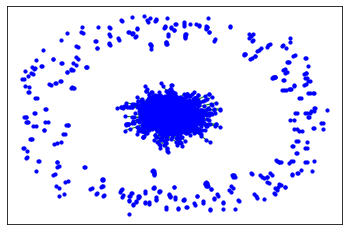

In [42]:
nx.draw_networkx(bio_graph, 
                       with_labels=False,
                       node_size=10,
                       node_color=('b'), 
                       edge_color=('g'),
                 

                       )
plt.show()

##2.1 Main network measures

#### a - global measures

In [157]:
avg_degree = sum(nx.average_neighbor_degree(bio_graph).values())/ nx.number_of_nodes(bio_graph)
avg_clus_coef = nx.average_clustering(bio_graph)


In [158]:
avg_paths = []
radiuses = []
diameters = []
for cc in nx.connected_components(bio_graph):
  g = bio_graph.subgraph(cc)   
  avg_paths.append(nx.average_shortest_path_length(g))
  radiuses.append(nx.radius(g))
  diameters.append(nx.diameter(g)) 


In [159]:
avg_path_lengths = np.mean(avg_paths)
radius = np.max(radiuses)
diameter = np.max(diameters)

In [160]:
print(f"Number of nodes               : {nx.number_of_nodes(bio_graph)}")
print(f"Number of Links               : {nx.number_of_edges(bio_graph)}")
print(f"Number of connected components: {nx.number_connected_components(bio_graph)}")
print(f"Number of isolated nodes      : {nx.number_of_isolates(bio_graph)}")
print(f"Average path length           : {avg_path_lengths}")
print(f"Average Degree                : {avg_degree}")
print(f"Average custering coefficient : {avg_clus_coef}")
print(f"Network radius                : {radius}")
print(f"Network diameter              : {diameter}")
print(f"Network centralization              : {'#TODO'}")

Number of nodes               : 4826
Number of Links               : 9916
Number of connected components: 204
Number of isolated nodes      : 0
Average path length           : 0.9100962842401638
Average Degree                : 17.148766044645775
Average custering coefficient : 0.09234960083891741
Network radius                : 8
Network diameter              : 15
Network centralization              : #TODO


#### b- LCC Measures

In [161]:
bio_graph_lcc = max(nx.connected_components(bio_graph), key=len)
bio_graph_lcc = bio_graph.subgraph(bio_graph_lcc)

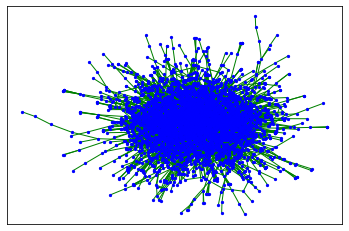

In [48]:
nx.draw_networkx(bio_graph_lcc, 
                 with_labels=False,
                 node_size=5,
                 node_color=('b'), 
                 edge_color=('g')
)
plt.show()

##### i - Global Measures

In [162]:
print(f"Number of nodes               : {nx.number_of_nodes(bio_graph_lcc)}")
print(f"Number of Links               : {nx.number_of_edges(bio_graph_lcc)}")
print(f"Number of connected components: {nx.number_connected_components(bio_graph_lcc)}")
print(f"Number of isolated nodes      : {nx.number_of_isolates(bio_graph_lcc)}")
print(f"Average path length           : {avg_path_lengths}")
#print(f"Average Degree                : {nx.de}")
print(f"Average custering coefficient : {nx.average_clustering(bio_graph_lcc)}")
print(f"Network radius                : {nx.radius(bio_graph_lcc)}")
print(f"Network diameter              : {nx.diameter(bio_graph_lcc)}")
print(f"Network centralization              : {'#TODO'}")

Number of nodes               : 4389
Number of Links               : 9613
Number of connected components: 1
Number of isolated nodes      : 0
Average path length           : 0.9100962842401638
Average custering coefficient : 0.09865857985462491
Network radius                : 8
Network diameter              : 15
Network centralization              : #TODO


##### ii - Local Measures

 ###### Node degree



In [163]:
g_degree = nx.degree(bio_graph_lcc)
degree_df = pd.DataFrame(g_degree, columns=['Node','Degree'])
#degree_df.head(10)

###### Betweenness centrality

In [164]:
g_b_centrality = nx.betweenness_centrality(bio_graph_lcc)
#g_b_centrality

###### Eigenvector centrality


In [165]:
g_e_centrality = nx.eigenvector_centrality(bio_graph_lcc)
#g_e_centrality

###### Closeness centrality

In [166]:
g_c_centrality = nx.closeness_centrality(bio_graph_lcc)
#g_c_centrality

##### Show all local measures

In [167]:
nodes = list(bio_graph_lcc.nodes)
nodes_degree = list(degree_df['Degree'].values)
b_centrality = list(g_b_centrality.values())
e_centrality = list(g_e_centrality.values())
c_centrality = list(g_c_centrality.values())


###### Ratio Betweenness/Node degree

In [168]:
ratio_b_d = np.array(b_centrality)/np.array(nodes_degree)

In [169]:
columns = ['nodes','Degree','Betweeness Centrality','Eigen centrality','closeness centrality','Ratio']
data = [nodes,nodes_degree,b_centrality,e_centrality,c_centrality,ratio_b_d]
data = np.array(data).T;
df = pd.DataFrame(data, columns=columns)
df.sort_values(by='Degree',ascending=False)

,nodes,Degree,Betweeness Centrality,Eigen centrality,closeness centrality,Ratio
1157,MDFI,98,0.03582301901057301,0.01609308194925159,0.25958353052531946,0.00036554101031196953
35,BRCA1,95,0.06595412084596748,0.07349077731555746,0.27933032019861226,0.000694253903641763
1441,XIAP,9,0.0012728305497665992,0.0007986838958323306,0.21734607954826887,0.00014142561664073325
58,MCM5,9,0.0018307059499518444,0.0017526477105750415,0.22688728024819027,0.0002034117722168716
2714,CDK5RAP3,9,0.002731341065139078,0.00012734864500706878,0.2038654525181193,0.00030348234057100867
...,...,...,...,...,...,...
2814,PDIA4,1,0.0,1.0271049349746429e-05,0.16869137321236352,0.0
2812,SLC4A7,1,0.0,9.804992573503242e-05,0.18106792110258316,0.0
2810,LCN1,1,0.0,2.461647894669171e-05,0.1797623924621057,0.0
2809,DFFB,1,0.0,8.438144785776394e-05,0.19601536674707407,0.0


#### 2.2 Clustering methods for disease modules discover

In [170]:
!pip install markov_clustering[drawing]

In [64]:
import markov_clustering as mc

In [65]:
#  get the adjacency matrix (in sparse form)
matrix = nx.to_scipy_sparse_matrix(bio_graph)

In [66]:
result = mc.run_mcl(matrix)           # run MCL with default parameters
clusters = mc.get_clusters(result)   # each element in cluster is represented by internal ID number

###### clusters with at least 10 nodes

In [67]:
# we retrieve cluster with at least 10 elements 
above_10_clusters = [cluster for cluster in clusters if len(cluster)>=10]

# We convert back the IDs to genes symbols
nodes_list = list(bio_graph.nodes)
symbols_clusters = [tuple([nodes_list[i] for i in cluster]) for cluster in above_10_clusters]

#### hypergeometric test

In [124]:
import random
from collections import Counter
from scipy.stats import hypergeom


In [69]:
collection =  list(all_proteins_interactions_df.iloc[:,:2].values.flatten())
collection_set = set(collection)

In [139]:
N_seed_genes = n_seed_biogrid # number of seedgenes in iogrid
N_all_genes = len(genes_biogrid)
N_non_seed_genes = N_all_genes - N_seed_genes
prob_seed = N_seed_genes / N_all_genes
prob_seed

0.004557054320087495

In [171]:
sample_size_max = 10



In [140]:
probs = {}
hpd = hypergeom(N_all_genes,N_seed_genes,sample_size_max)
for x in range(1,sample_size_max):
  probs[x] = hpd.pmf(x)

probs

{1: 0.043752861133658456,
 2: 0.0008926497360273107,
 3: 1.0682746302870106e-05,
 4: 8.303856511132288e-08,
 5: 4.38025674278221e-10,
 6: 1.5877762155442661e-12,
 7: 3.904869982719714e-15,
 8: 6.234884197727557e-18,
 9: 5.8356793296410964e-21}

For p < 0.05 we have to find sample with at least 1 seed gene

#### Check cluster that contains the over represented Nodes

In [143]:
putative_disease_modules = []
for cluster in symbols_clusters:
  s = len(set(cluster).intersection(set(seed_genes_ids)))
  if s > 0:
    putative_disease_modules.append(cluster)

#putative_disease_modules

In [149]:
module_data = []
columns = ['module ID', 'no.of seed genes in the module',
           'total no. of genes in each module', 'seed gene IDs', 'all gene IDs in the module', 'p-value']
for id,module in enumerate(putative_disease_modules):
  module_id = f'MOD_{id}'
  n_seed_gene = len(set(module).intersection(set(seed_genes_ids)))
  module_size = len(module)
  seed_genes = ','.join(set(module).intersection(set(seed_genes_ids)))
  all_genes = ','.join(module)
  p_value = hypergeom(N_all_genes,N_seed_genes,total_n).pmf(n_seed_gene)

  module_data.append([module_id,n_seed_gene,module_size,seed_genes,all_genes,p_value])

  

In [150]:
moduledf = pd.DataFrame(module_data,columns=columns)
moduledf

,module ID,no.of seed genes in the module,total no. of genes in each module,seed gene IDs,all gene IDs in the module,p-value
0,MOD_0,1,54,SIPA1L1,"SFN,CDC42EP1,FAM189A2,BAG3,CHST1,MAPKAP1,IRS2,...",0.043753
1,MOD_1,1,50,KCNMB1,"FASN,EWSR1,ZDHHC3,MYL6,NUDT21,SLC22A24,MVK,PGL...",0.043753
2,MOD_2,1,26,TNF,"TRAIP,FLII,TRAF1,HIVEP3,TRAF2,TNFRSF25,TRADD,F...",0.043753
3,MOD_3,1,14,MYO1B,"EIF4A1,AKAP17A,EIF4E,EIF4A2,PDCD4,MYO1B,EIF4G3...",0.043753
4,MOD_4,1,51,VIM,"KIAA0408,CCDC85B,CEP70,VIM,KANSL1,ZBTB43,ZC2HC...",0.043753
5,MOD_5,1,30,NDUFB9,"MAGEA11,MGME1,ENOX1,DNAJC10,MXD3,COX7A2L,ACTN1...",0.043753
6,MOD_6,1,10,TPM4,"SF3A3,TCERG1,RNU2-1,RNU1-4,PRPF40A,SF3A1,DNAJB...",0.043753
